This is to explore the average weights between genes co-annotated to the same Ontology term, vs. background

In [1]:
import numpy as np
import pandas as pd

import scipy.stats

import sys
import os

sys.path.append('../lib')
from Dab import Dab
from Gmt import read_gmt

import itertools

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [22]:
def mean_coannotated_weight(dab, gene_set):
    """Returns the average weight for connections between genes in the provided gene_set
        dab - a Dab object for the network in question
        gene_set - a list of gene names (matching the names used in dab.genes)
    """
    name_to_idx = {}
    for i in range(len(dab.genes)):
        name_to_idx[dab.genes[i]] = i
    
    set_idxs = [name_to_idx[g] for g in gene_set if g in name_to_idx]
    coannotated_pairs = set((x,y) for (x,y) in itertools.combinations(set_idxs, 2))
    return sum(dab.weights[x,y] for (x,y) in coannotated_pairs) / len(coannotated_pairs)


In [4]:
def co_annotation_counts(dab, gene_sets):
    co_annotated_pairs = {}
    name_to_idx = {}

    for i in range(len(dab.genes)):
        name_to_idx[dab.genes[i]] = i

    def register_pair(i, j):
        if (i,j) in co_annotated_pairs:
            co_annotated_pairs[(i,j)] += 1
        else:
            co_annotated_pairs[(i,j)] = 1

    def process_set(s):
        ids = sorted(name_to_idx[g] for g in s if g in name_to_idx)
        for (i,j) in itertools.combinations(ids, 2):
            register_pair(i,j)

    for s in gene_sets.values():
        process_set(s)
    
    return co_annotated_pairs

In [3]:
d = Dab('../data/brain.dab')

In [52]:
gene_sets = read_gmt('go_human_bp.gmt')

In [23]:
def filter_gene_sets(dab, gene_sets, size_range=(2, 150)):
    """Filter gene sets to only include genes listed in dab.genes. Optionally filter 
       to only include gene sets from size_range=(min_size, max_size). Substitute None
       for one edge of range to leave unconstrained"""
    all_genes = set(dab.genes)
    gene_sets = {k: [g for g in v if g in all_genes] for (k, v) in gene_sets.iteritems()}
    if size_range[0]:
        gene_sets = {k: v for (k,v) in gene_sets.iteritems() if len(v) >= size_range[0] }
    if size_range[1]:
        gene_sets = {k: v for (k,v) in gene_sets.iteritems() if len(v) <= size_range[1] }
    return gene_sets


def get_coannotated_weight(dab, gene_sets):
    """Plots the average weight for genes co-annotated to GO terms"""
    #Make the DataFrame
    f = pd.DataFrame({"go_id":gene_sets.keys()})
    f['size'] = [len(gene_sets[r.go_id]) for r in f.itertuples()]
    f['coannotated_weight'] = [mean_coannotated_weight(d, gene_sets[r.go_id]) for r in f.itertuples()]
    
    return f

def plot_coannotated_weight(frame, dab_name, gene_sets_name):
    f.plot.scatter('size', 'coannotated_weight')
    plt.title('size vs. mean coannotated weight\n' + dab_name + ' w/ ' + gene_sets_name)
    plt.axhline(y=d.weights.mean())
    plt.tight_layout()
    plt.show()

In [21]:
#gene_sets = filter_gene_sets(d, gene_sets)
%timeit -n1 -r1 f = get_coannotated_weight(d, gene_sets)

1 loop, best of 1: 1min 18s per loop


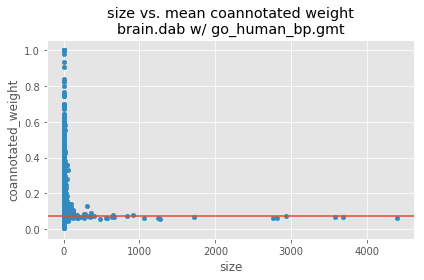

In [60]:
plot_coannotated_weight(f, "brain.dab", "go_human_bp.gmt")

Next, I'll try some combinations of GO term sources with dab files:
##### GMT Files
- go_human_bp.gmt -- Biological Process terms from NCBI gene2go
- go_human_components.gmt -- Component terms from NCBI gene2go
- gobp_human.closed.gmt -- Biological Process terms from Troyanskaya lab machine (sources unclear)

##### Dab Files
- brain.dab -- brain network downloaded from giant.princeton.edu (+ filtered for pegged genes)
- brain.cor.cab -- correlated version of brain.dab
- brain_r04.dab -- renormalized network downloaded from Troyanskaya lab machines
- brain_r04.cor.dab -- correlated version of brain_r04.dab

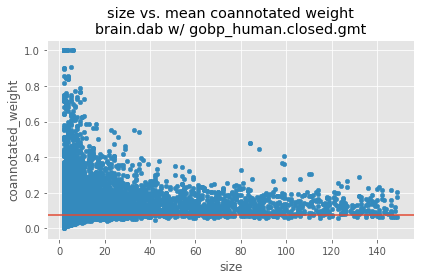

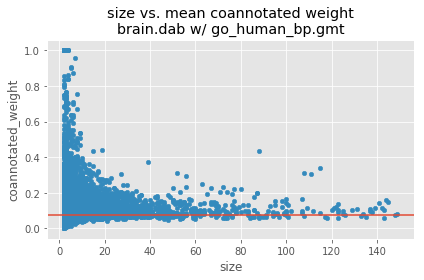

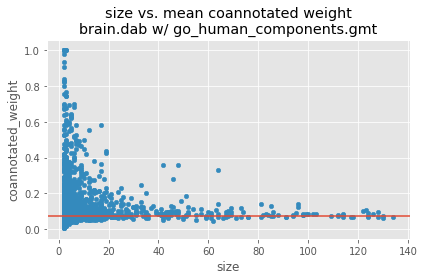

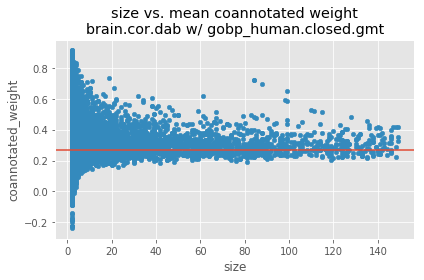

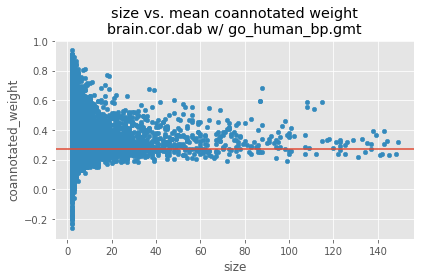

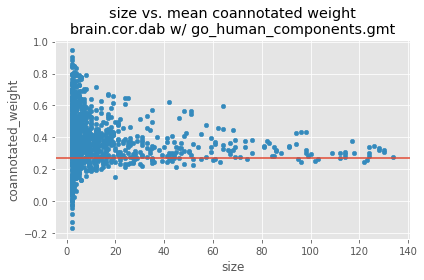

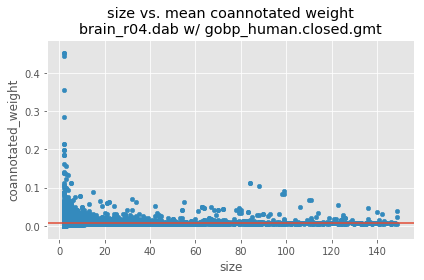

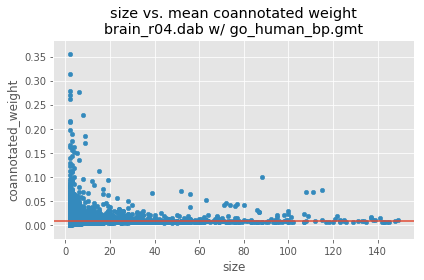

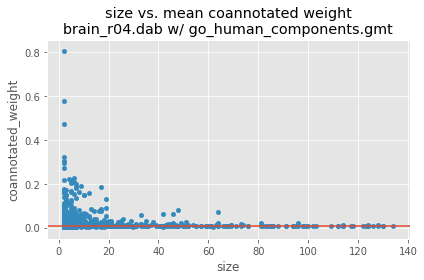

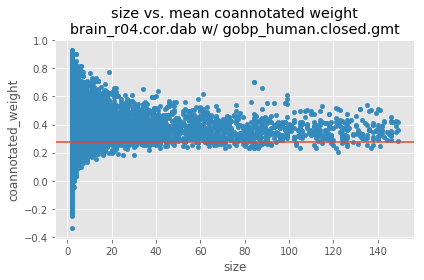

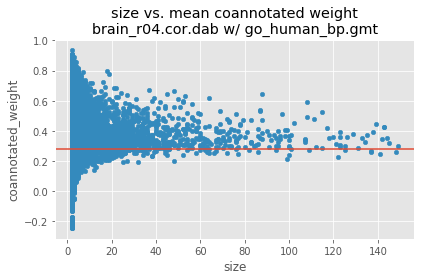

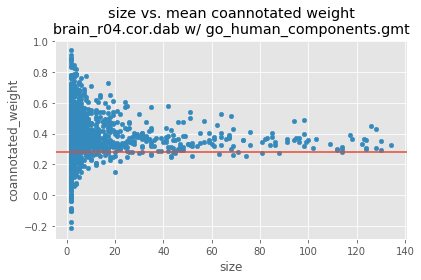

In [70]:
frames = []
for dab_file in ['brain.dab', 'brain.cor.dab', 'brain_r04.dab', 'brain_r04.cor.dab']:
    d = Dab('../data/' + dab_file)
    for go_file in ['gobp_human.closed.gmt', 'go_human_bp.gmt', 'go_human_components.gmt']:
        gene_set = read_gmt(go_file)
        #Filter to gene sets of size 150 and less
        gene_set = filter_gene_sets(d, gene_set)
        f = get_coannotated_weight(d, gene_set)
        frames.append((dab_file, go_file, f))
        plot_coannotated_weight(f, dab_file, go_file)

In [6]:
def get_linear_weights(dab):
    N = len(dab.genes)
    lin = np.zeros((N*(N-1))/2, dtype=np.float64)
    cur_idx = 0
    for i in range(N-1):
        lin[cur_idx:cur_idx+N-i-1] = dab.weights[i, i+1:N]
        cur_idx += N-i-1
    return lin

In [ ]:
average_weights = {'dab_file':[],'gene_sets':[], 'mean_weight':[], 'mean_coannotated_weight':[],
                    'network_size':[], 'coannotations':[]}

for dab_file in ['brain.dab', 'brain.cor.dab', 'brain_r04.dab', 'brain_r04.cor.dab']:
    d = Dab('../data/' + dab_file)
    network_mean = get_linear_weights(d).mean()
    for go_file in ['gobp_human.closed.gmt', 'go_human_bp.gmt', 'go_human_components.gmt']:
        gene_sets = read_gmt(go_file)
        gene_sets = {k: v for (k,v) in gene_sets.iteritems() if len(v) < 150}
        average_weights['dab_file'].append(dab_file)
        average_weights['gene_sets'].append(go_file)
        average_weights['mean_weight'].append(network_mean)
        average_weights['network_size'].append((len(d.genes) * (len(d.genes)-1))/2)

        coannotation_counts = co_annotation_counts(d, gene_sets)
        average_weights['coannotations'].append(len(coannotation_counts))
        average_weights['mean_coannotated_weight'].append(
            sum(d.weights[x,y] for (x,y) in coannotation_counts.keys()) / len(coannotation_counts)
        )


average_weights = pd.DataFrame(average_weights)

In [92]:
average_weights

coannotations           dab_file                gene_sets  \
0         1569993          brain.dab    gobp_human.closed.gmt   
1          941832          brain.dab          go_human_bp.gmt   
2          369373          brain.dab  go_human_components.gmt   
3         1569993      brain.cor.dab    gobp_human.closed.gmt   
4          941832      brain.cor.dab          go_human_bp.gmt   
5          369373      brain.cor.dab  go_human_components.gmt   
6         1569993      brain_r04.dab    gobp_human.closed.gmt   
7          941832      brain_r04.dab          go_human_bp.gmt   
8          369373      brain_r04.dab  go_human_components.gmt   
9         1569993  brain_r04.cor.dab    gobp_human.closed.gmt   
10         941832  brain_r04.cor.dab          go_human_bp.gmt   
11         369373  brain_r04.cor.dab  go_human_components.gmt   

    mean_coannotated_weight  mean_weight  network_size  
0                  0.105087     0.072241     329949516  
1                  0.095842     0.072241     329949516  
2                  0.088693     0.072241     329949516  
3                  0.295707     0.269494     329949516  
4                  0.313165     0.269494     329949516  
5                  0.324097     0.269494     329949516  
6                  0.007448     0.007121     329949516  
7                  0.008397     0.007121     329949516  
8                  0.009320     0.007121     329949516  
9                  0.352412     0.277343     329949516  
10                 0.351332     0.277343     329949516  
11                 0.352164     0.277343     329949516

# Important Note:
I forgot to put a square root on the denominator of the norm.sf scale parameter for many of these, so the counts of significant genes are way inflated

##### Plot with significance bars on it

Adding lines to show significance cutoffs on the plot

In [7]:
base_dir = "/Users/ben/Documents/IW Networks/"
d = Dab(base_dir + "r04/global.dab")
gene_sets = read_gmt("gobp_human.closed.gmt")

In [24]:
#Filter to gene sets of size 150 and less
gene_sets = filter_gene_sets(d, gene_sets)

f = get_coannotated_weight(d, gene_sets)

In [9]:
lin_weights = get_linear_weights(d)
stddev = lin_weights.std()
mean = lin_weights.mean()
lin_weights = None
print stddev, mean

0.0107777737741 0.00724071364063


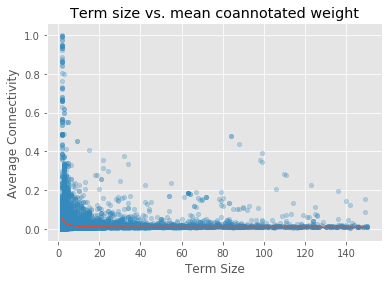

In [25]:
from scipy.stats import norm

ax = f.plot.scatter('size', 'coannotated_weight', alpha=0.3)
ax.set_xlabel("Term Size")
ax.set_ylabel("Average Connectivity")
plt.title('Term size vs. mean coannotated weight')
#plt.axhline(mean, color='black')

x = np.array(range(2,150))
#Plot a significance cutoff, with a 0.05 Bonferonni adjusted p-value
p_cutoff = 0.05 / len(f)
y = norm.isf(p_cutoff, loc=mean, scale=stddev/np.sqrt((x*(x-1))/2))
plt.plot(x, y)
plt.show()

In [26]:
f['p_val'] = [norm.sf(r.coannotated_weight, loc=mean, scale=stddev/((r.size*(r.size-1))/2.0)) for r in f.itertuples()]
print "Significant adjusted terms:", len(f.query('p_val < %r' % p_cutoff)), "out of", len(f)

Significant adjusted terms: 4576 out of 7248


#### Repeat the same idea, but using the correlation network

In [29]:
base_dir = "/Users/ben/Documents/IW Networks/"
gene_sets = read_gmt("gobp_human.closed.gmt")


d = Dab(base_dir + "r04/global.dab.cor")
gene_sets = filter_gene_sets(d, gene_sets)
print "Read Dab + gmt"

f2 = get_coannotated_weight(d, gene_sets)
print "Calculated coannotated weight"
lin_weights = get_linear_weights(d)
stddev2 = lin_weights.std()
mean2 = lin_weights.mean()
lin_weights = None
print stddev, mean

Read Dab + gmt
Calculated coannotated weight
0.0107777737741 0.00724071364063


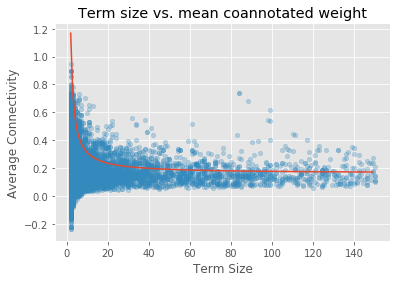

In [32]:
from scipy.stats import norm

ax = f2.plot.scatter('size', 'coannotated_weight', alpha=0.3)
ax.set_xlabel("Term Size")
ax.set_ylabel("Average Connectivity")
plt.title('Term size vs. mean coannotated weight')
#plt.axhline(mean, color='black')

x = np.array(range(2,150))
#Plot a significance cutoff, with a 0.05 Bonferonni adjusted p-value
p_cutoff = 0.05 / len(f2)
y1 = norm.isf(p_cutoff, loc=mean2, scale=stddev2/np.sqrt((x*(x-1))/2))
plt.plot(x, y1)
plt.show()

In [34]:
f2['p_val'] = [norm.sf(r.coannotated_weight, loc=mean2, scale=stddev2/((r.size*(r.size-1))/2.0)) for r in f2.itertuples()]
print "Significant adjusted terms:", len(f2.query('p_val < %r' % p_cutoff)), "out of", len(f2)

Significant adjusted terms: 2127 out of 7248


##### Try now with the cosine distance network

In [35]:
base_dir = "/Users/ben/Documents/IW Networks/"
gene_sets = read_gmt("gobp_human.closed.gmt")

d = Dab(base_dir + "r04/global.dab.cosine")
gene_sets = filter_gene_sets(d, gene_sets)
print "Read Dab + gmt"

f3 = get_coannotated_weight(d, gene_sets)
print "Calculated coannotated weight"
lin_weights = get_linear_weights(d)
stddev3 = lin_weights.std()
mean3 = lin_weights.mean()
lin_weights = None
print stddev, mean

Read Dab + gmt
Calculated coannotated weight
0.0107777737741 0.00724071364063


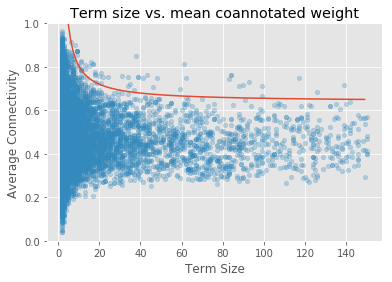

In [38]:
from scipy.stats import norm

ax = f3.plot.scatter('size', 'coannotated_weight', alpha=0.3)
ax.set_xlabel("Term Size")
ax.set_ylabel("Average Connectivity")
ax.set_ylim([0,1])
plt.title('Term size vs. mean coannotated weight')
#plt.axhline(mean, color='black')

x = np.array(range(2,150))
#Plot a significance cutoff, with a 0.05 Bonferonni adjusted p-value
p_cutoff = 0.05 / len(f3)
y1 = norm.isf(p_cutoff, loc=mean3, scale=stddev3/np.sqrt((x*(x-1))/2))
plt.plot(x, y1)
plt.show()

In [42]:
f3['p_val'] = [norm.sf(r.coannotated_weight, loc=mean3, scale=stddev3/((r.size*(r.size-1))/2.0)) for r in f3.itertuples()]
print "Significant adjusted terms:", len(f3.query('p_val < %r' % p_cutoff)), "out of", len(f3)

Significant adjusted terms: 287 out of 7248
